In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import itertools, functools
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import math
import seaborn as sns
%matplotlib inline
def set_axes_equal(ax):
    '''Make axes of 3D plot have equal scale so that spheres appear as spheres,
    cubes as cubes, etc..  This is one possible solution to Matplotlib's
    ax.set_aspect('equal') and ax.axis('equal') not working for 3D.

    Input
      ax: a matplotlib axis, e.g., as output from plt.gca().
    '''
    ax.set_aspect('equal')
    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)

    # The plot bounding box is a sphere in the sense of the infinity
    # norm, hence I call half the max range the plot radius.
    plot_radius = 0.5*max([x_range, y_range, z_range])

    ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
    ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
    ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])

In [58]:
coorddata = pd.read_csv('node_coords.csv',dtype={'Node':np.int64,'x': np.float64,'y': np.float64,'z': np.float64})
coorddata['faceloc'] = coorddata.apply(lambda row: row['aFace']+row['aLocation'], axis=1)
xs = coorddata['x']
ys = coorddata['y']
zs = coorddata['z']
def faceloc_to_coords(coorddata, faceloc):
    coords= coorddata[coorddata['faceloc']==faceloc][['x','y','z']].values.tolist()
    return tuple(coords[0])
def add_modeshape(coords, modeshape):
    newdf = pd.merge(modeshape,coorddata,how='right', on=['Node'])
    orrer = lambda x: 0 if math.isnan(x) else x 
    newdf['x'] = newdf.apply(lambda row: row['x']+orrer(row['xx']), axis =1)
    newdf['y'] = newdf.apply(lambda row: row['y']+orrer(row['yy']), axis =1)
    newdf['z'] = newdf.apply(lambda row: row['z']+orrer(row['zz']), axis =1)
    return newdf
def loadit(fname, factor):
    m = pd.read_csv(fname)
    for col in ['xx','yy','zz']:
        m[col] = m[col].apply(lambda x:x*factor)
    return m
#modeshapedummy = pd.DataFrame({'Node':[20],'xx':[10],'yy':[2],'zz':[4]})
m = loadit('fddmodeshape.csv',1.5)
mshape_data = add_modeshape(coorddata, m)

In [59]:
df = pd.read_csv('structure_graph.csv')
df['faceloc'] = coorddata.apply(lambda row: row['aFace']+row['aLocation'], axis=1)

def dictify(graphdf):
    d = df.to_dict('records')
    adjlist = ['adj'+str(i) for i in range(1,9)]
    onerec = lambda item:(item['faceloc'],[item.get(l) for l in adjlist])
    allrecs = [onerec(i) for i in d]
    filterer = lambda tpl: (tpl[0], [i for i in tpl[1] if i==i])
    filtered = map(filterer, allrecs)
    def accumer(accum, el):
        accum[el[0]]=el[1]
        return accum
    return functools.reduce(accumer, filtered, {})
def adjacency_to_pairs(d):
    """take a adjacency structure d like:
    {'a':['b','c'], 'b':['a','c']}
    and return all pairs,e.g.
    [('a','b'),('a','c')...]"""
    nested_pairs = (list(itertools.product([k],v)) for k,v in d.items())
    flattener = lambda nested: itertools.chain(*nested)
    return list(flattener(nested_pairs))
graphstruct = dictify(df)
graphpairs = adjacency_to_pairs(graphstruct)
translater = functools.partial(faceloc_to_coords, mshape_data)#coorddata)
coorded_pairs = [(translater(k),translater(v)) for k,v in graphpairs]
def pairs_to_lines(pair):
    """take a pairs where each item is x,y,z
    and return three lists for plotting lines """
    return [i[0] for i in pair], [i[1] for i in pair], [i[2] for i in pair]

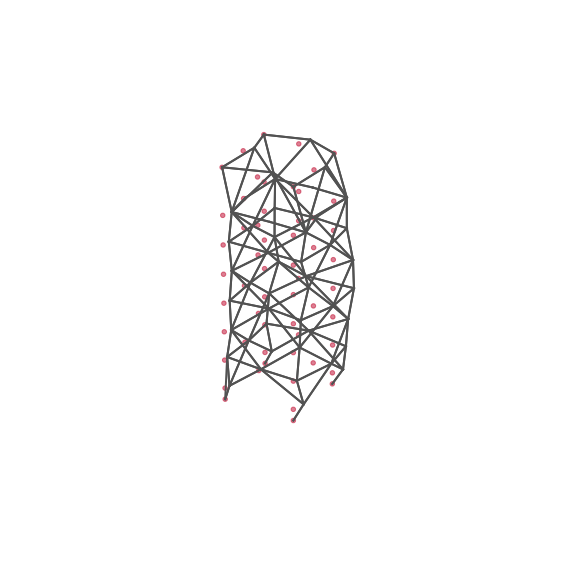

In [60]:
fig = plt.figure()
fig.set_size_inches(8,8)
ax = plt.gca(projection='3d')
ax.set_axis_off()

# Data for a three-dimensional line
#zline = np.linspace(0, 15, 1000)
#xline = np.sin(zline)
#yline = np.cos(zline)
def shared_coord(pair, xyz, val):
    d = {'x':0,'y':1,'z':2}
    ax = d[xyz]
    return int(pair[0][ax])==val and int(pair[1][ax])==val
for pair in coorded_pairs:
    xl,yl,zl = pairs_to_lines(pair)
    oneface = 'frontface' if shared_coord(pair, 'x',0) else False
    rightface = 'rightface' if shared_coord(pair, 'y',0) else False
    backleg = 'backleg' if (shared_coord(pair, 'x',-6) and shared_coord(pair,'y',6)) else False
    rightleg = 'rightleg' if shared_coord(pair, 'x',0) and shared_coord(pair,'y',6) else False
    frontleg = 'frontleg' if shared_coord(pair, 'x',-6) and shared_coord(pair,'y',0) else False
    leftleg = 'leftleg' if shared_coord(pair, 'x',0) and shared_coord(pair,'y',0) else False
    width_dict = {'frontface':2, 'backleg':0.25, 'rightleg':2,'frontleg':2,'leftleg':2, 'rightface':2}
    any_cats = [backleg, rightleg, oneface,frontleg,leftleg, rightface]
    width = max([width_dict.get(cat,0.25) for cat in any_cats])
    ax.plot3D(xl, yl, zl, '#525252', alpha =1, linewidth=2)

# Data for three-dimensional scattered points
zdata = 15 * np.random.random(100)
xdata = np.sin(zdata) + 0.1 * np.random.randn(100)
ydata = np.cos(zdata) + 0.1 * np.random.randn(100)
ax.scatter3D(xs, ys, zs, alpha = 0.5, color ='#bd0026')
set_axes_equal(ax)
fig.tight_layout()
fig.savefig('tower3d.png', format='png', dpi=600)